## Запускается на колабе

см. https://drive.google.com/drive/folders/1t-RrkkEU1cVZrpE0ZLnSt4O6Ti1N3176?usp=sharing

Можно сделать алиас на эту папку, чтобы работало. Но не получиться сохранять графики, потому что ссылка даёт доступ на читателя. Стоит закомментировать строчки:

`plt.savefig('/content/drive/MyDrive/m1p/figs/{}.png', bbox_inches='tight')`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tqdm import tqdm
from typing import Dict
import time

import torch
import torch.nn as nn
import torch.fx
from torch.distributions.uniform import Uniform

import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

import sys
sys.path.append('/content/drive/MyDrive/m1p')

from fast_nas_adapt.src.resnet18 import ResNet18
from fast_nas_adapt.src.module2graph import GraphInterperterWithGamma


In [3]:
class GraphInterperterWithGumbelSoftmaxGamma(GraphInterperterWithGamma):
    def __init__(self, mod, gamma_shift=0.0, temperature=1.0):
        self.gamma_shift = gamma_shift
        self.temperature = temperature
        super().__init__(mod)

    def init_gammas(self):
        i = 0
        gammas = []
        self.gammas_name = {}
        for node in self.graph.nodes:
            if node.op == 'call_module':
                gammas.append(np.random.randn()+self.gamma_shift)
                self.gammas_name[str(node)] = i# перевод в str тут для удобства. в реалньых методах это не нужно
                i+=1                        # да и вообще, тут по идее должен быть тензор/параметр
        self.gammas = torch.as_tensor(gammas)
        self.discrete = False 

    def sample_gammas(self, previous=False):
        if previous:
            return self.previous_sample

        if self.discrete:
            return self.gammas
        else:
            d = torch.distributions.RelaxedBernoulli(logits=self.gammas, temperature=self.temperature)
            self.previous_sample = d.rsample()
            return self.previous_sample
        
    def make_gammas_discrete(self):
        self.gammas.data = (self.gammas.data>=0) * 1.0
        self.discrete = True

In [4]:
class HyperNet(nn.Module):
    def __init__(self, out_size, hidden_layer_num=1, hidden_size=128):
        """
        :param hidden_layer_num: количество скрытых слоев (может быть нулевым)
        :param hidden_size: количество нейронов на скрытом слое (актуально, если скрытые слои есть)
        :param out_size: количество параметров
        """
        nn.Module.__init__(self)

        layers = []
        in_ = 1 # исходная входная размерность
        for _ in range(hidden_layer_num):
            layers.append(nn.Linear(in_, hidden_size))
            layers.append(nn.ReLU())
            in_ = hidden_size
        layers.append(nn.Linear(in_, out_size))

        self.model = nn.Sequential(*layers)

    def forward(self, lambd):
        return self.model(lambd)

Получим претрейн на n эпох

In [5]:
model = ResNet18(num_classes=10).cuda()

model_path = '/content/drive/MyDrive/m1p/pretrained/model_23.ckpt'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [6]:
from fast_nas_adapt.src.cifar_data import get_dataloaders

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64,
                                    img_size=33)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
@torch.no_grad()
def validate(model, dataloader, device):
    model = model.to(device)
    n_true = 0
    n_tot = 0
    for i, (X, y) in tqdm(enumerate(dataloader), 'validating'):
        if X.shape[0] != 64:
            continue
        n_true += (model(X.to(device)).argmax(-1) == y.to(device)).sum().item()
        n_tot += 64
    return n_true / n_tot

In [8]:
validate(model, test_dl, 'cuda')

validating: 157it [00:03, 41.10it/s]


0.6464342948717948

Гиперпараметры:

In [17]:
device = 'cuda'

imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), 4, temperature=0.2).to(device).eval()

params_count = len(imodel.gammas)
hypernet = HyperNet(params_count, hidden_layer_num=0).to(device)

optimizer = torch.optim.Adam(hypernet.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

times_path = "/content/drive/MyDrive/m1p/ResNet18HomeMeasurments.csv"
times = pd.read_csv(times_path, index_col=0)
times = torch.tensor(times['mean'], dtype=torch.float32).cuda()
times /= times.sum()

In [18]:
gammas = hypernet(torch.tensor([float(0)]).to(device))
((gammas>0) * 1.0).sum().item()

30.0

In [19]:
EPOCHS = 3*1
lambd = Uniform(0, .00001)

hypernet_states = []
hypernet.train()

for epoch in range(EPOCHS):
    for i, (X, y) in tqdm(enumerate(train_dl), 'training', total=len(train_dl)):
        if X.shape[0] != 64:
            continue

        l = lambd.sample().to(device).view(1)

        optimizer.zero_grad()

        gammas = hypernet(l)
        imodel.gammas = gammas
        y_pred = imodel(X.to(device))
        loss = loss_fn(y_pred, y.to(device))# + l * imodel.sample_gammas(previous=True).dot(times)
        # loss = ((gammas - 1)**2).sum()
        loss.backward()
        
        optimizer.step()

    hypernet_states.append(hypernet.state_dict())

training: 100%|██████████| 782/782 [00:19<00:00, 40.33it/s]


In [20]:
gammas = hypernet(torch.tensor([float(0)]).to(device))
((gammas>0) * 1.0).sum().item()

24.0

In [13]:
lambds = [0, 1, 2, 5, 10]

accs = []

hypernet.load_state_dict(hypernet_states[-1])

for lambd in lambds:
    gammas = hypernet(torch.tensor([float(lambd)]).to(device))
    imodel.gammas = gammas
    imodel.make_gammas_discrete()

    acc = validate(imodel, test_dl, device)
    accs.append(acc)

imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), 4, temperature=0.2).to(device).eval()

validating: 157it [00:01, 108.65it/s]
validating: 157it [00:01, 106.92it/s]
validating: 157it [00:02, 77.74it/s]
validating: 157it [00:01, 90.09it/s] 
validating: 157it [00:01, 107.24it/s]


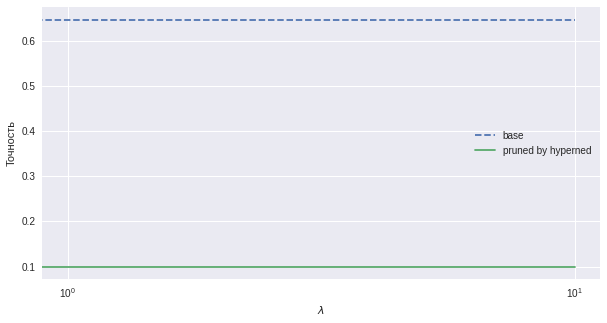

In [14]:
plt.figure(figsize=(10,5))

base_acc = 0.6464342948717948
plt.plot([lambds[0], lambds[-1]], [base_acc, base_acc], ls='--', label="base")

plt.plot(lambds, accs, label="pruned by hyperned")

plt.xscale('log')
plt.ylabel('Точность')
plt.xlabel('$\lambda$')

plt.legend()
plt.savefig('/content/drive/MyDrive/m1p/figs/accuracy_versus_lambda_hypernet.png', bbox_inches='tight')

In [15]:
# lambds = [0, 1, 2, 5, 10]
# history = {l: [] for l in lambds}

# for hypernet_state in hypernet_states:
#     hypernet.load_state_dict(hypernet_state)

#     for lambd in lambds:
#         gammas = hypernet(lambd)
#         imodel.gammas = gammas
#         imodel.make_gammas_discrete()

#         acc = validate(imodel, test_dl, device)
#         history[lambd].append(acc)

In [16]:
# plt.figure(figsize=(10,5))

# base_acc = 0.6464342948717948
# plt.plot([1, EPOCHS], [base_acc, base_acc], ls='--', label="base")

# for lambd, accs in history.items():
#     plt.plot(np.arange(EPOCHS)+1, accs, label=f"$\lambda={lambd}$")

# plt.ylabel('Точность')
# plt.xlabel('Эпоха')

# plt.legend()
# plt.savefig('/content/drive/MyDrive/m1p/figs/learning_curve_hypernet.png', bbox_inches='tight')